#Importing necessary libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import nltk

#Importing dataset

In [14]:
df=pd.read_csv("amazon_data.csv")

In [4]:
df.head()

,review,rating
0,It was nice produt. I like it's design a lot. ...,5
1,awesome sound....very pretty to see this nd th...,5
2,awesome sound quality. pros 7-8 hrs of battery...,4
3,I think it is such a good product not only as ...,5
4,awesome bass sound quality very good bettary l...,5


In [5]:
df.tail()

,review,rating
9971,GoodREAD MORE,5
9972,Everything is amazimg but the built is very li...,5
9973,GoodREAD MORE,5
9974,Best headphone i have ever used....READ MORE,5
9975,NiceREAD MORE,5


In [6]:
df.shape

(9976, 2)

In [7]:
df.columns

Index(['review', 'rating'], dtype='object')

In [8]:
df.isnull().sum()

,0
review,0
rating,0


In [15]:
df.duplicated().sum()

2108

In [16]:
df=df.drop_duplicates()


In [17]:
df.duplicated().sum()


0

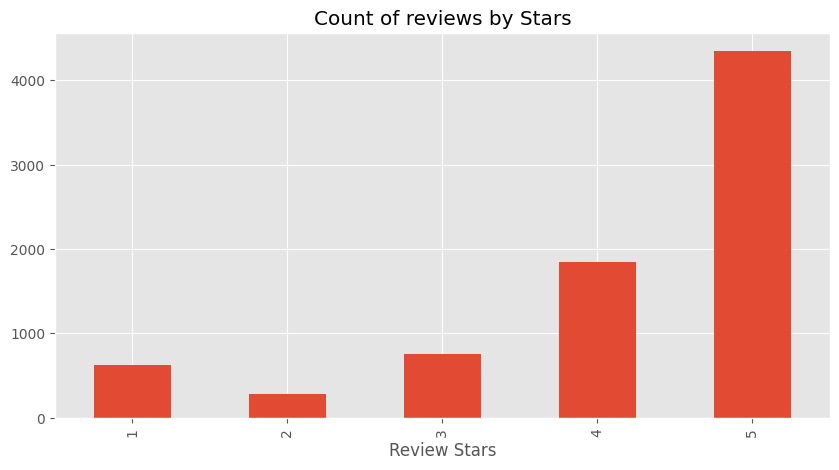

In [18]:
ax=df['rating'].value_counts().sort_index() \
    .plot(kind='bar',title='Count of reviews by Stars',
          figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()

#Using Vaders


In [19]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [20]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia=SentimentIntensityAnalyzer()


In [21]:
sia.polarity_scores('I am so happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [22]:
def get_polarity(text):
    try:
        return sia.polarity_scores(str(text))
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return {'pos': None, 'neu': None, 'neg': None, 'compound': None}

In [23]:
row_polarity_dict = {}
for index, row in df.iterrows():
    polarity = get_polarity(row['review'])
    row_polarity_dict[index] = {
        'id': index,
        'neg': polarity['neg'],
        'neu': polarity['neu'],
        'pos': polarity['pos'],
        'compound': polarity['compound'],
        'rating': row['rating'],
        'review': row['review']
    }
vaders = pd.DataFrame.from_dict(row_polarity_dict, orient='index')


In [24]:
vaders=pd.DataFrame(row_polarity_dict).T
vaders=vaders.reset_index().rename(columns={'id':'Id'})
vaders=vaders.merge(df,how='left')


In [25]:
vaders

,index,Id,neg,neu,pos,compound,rating,review
0,0,0,0.0,0.613,0.387,0.802,5,It was nice produt. I like it's design a lot. ...
1,1,1,0.0,0.517,0.483,0.9501,5,awesome sound....very pretty to see this nd th...
2,2,2,0.0,0.823,0.177,0.931,4,awesome sound quality. pros 7-8 hrs of battery...
3,3,3,0.0,0.672,0.328,0.9851,5,I think it is such a good product not only as ...
4,4,4,0.0,0.595,0.405,0.9053,5,awesome bass sound quality very good bettary l...
...,...,...,...,...,...,...,...,...
7863,9965,9965,0.0,0.408,0.592,0.4404,4,good headphoneREAD MORE
7864,9967,9967,0.636,0.364,0.0,-0.5423,1,Bad product.READ MORE
7865,9968,9968,0.0,1.0,0.0,0.0,4,It's tight and not more comfortableREAD MORE
7866,9972,9972,0.0,1.0,0.0,0.0,5,Everything is amazimg but the built is very li...


In [ ]:
sns.barplot(data=vaders,x='rating',y='compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

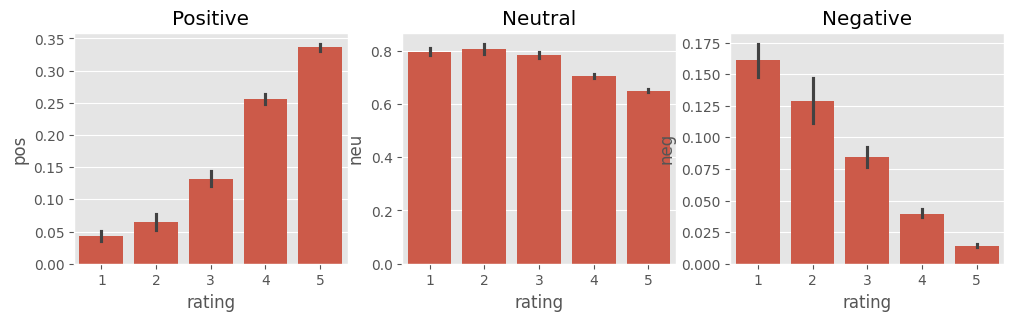

In [28]:
fig,axs=plt.subplots(1,3,figsize=(12,3))
sns.barplot(data=vaders,x='rating',y='pos',ax=axs[0])
sns.barplot(data=vaders,x='rating',y='neu',ax=axs[1])
sns.barplot(data=vaders,x='rating',y='neg',ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

In [29]:
 from transformers import AutoTokenizer
 from transformers import AutoModelForSequenceClassification
 from scipy.special import softmax

In [30]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [31]:
example=df['review'][10]
encoded_text = tokenizer(example,return_tensors='pt')
output=model(**encoded_text)
scores=output[0][0].detach().numpy()
scores=softmax(scores)
scores_dict = {
    'roberta_neg':scores[0],
    'roberta_neu':scores[1],
    'roberta_pos':scores[2],
}
print(scores_dict)

{'roberta_neg': 0.0028102365, 'roberta_neu': 0.03709882, 'roberta_pos': 0.9600909}


In [32]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example,return_tensors='pt')
  output=model(**encoded_text)
  scores=output[0][0].detach().numpy()
  scores=softmax(scores)
  scores_dict = {
    'roberta_neg':scores[0],
    'roberta_neu':scores[1],
    'roberta_pos':scores[2],
  }
  return scores_dict

In [33]:
from tqdm import tqdm

results_dict = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review']
    vader_result = sia.polarity_scores(text)
    vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}
    roberta_result = polarity_scores_roberta(text)
    combined_results = {**vader_result_rename, **roberta_result}
    results_dict[i] = {
        'id': i,
        **combined_results,
        'rating': row['rating'],
        'review': row['review']
    }
    if i==1:
      break
results_df = pd.DataFrame.from_dict(results_dict, orient='index')


  0%|          | 1/7868 [00:00<1:02:38,  2.09it/s]


In [34]:
import pandas as pd
# Example using pickle:
results_df.to_pickle("vader_roberta_results.pkl")
# Example using CSV:
results_df.to_csv("vader_roberta_results.csv", index=False)
loaded_results_df = pd.read_pickle("vader_roberta_results.pkl")
loaded_results_df = pd.read_csv("vader_roberta_results.csv")
print(loaded_results_df.head())

   id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0   0        0.0      0.613      0.387          0.8020     0.001534   
1   1        0.0      0.517      0.483          0.9501     0.002113   

   roberta_neu  roberta_pos  rating  \
0     0.012108     0.986358       5   
1     0.007681     0.990206       5   

                                              review  
0  It was nice produt. I like it's design a lot. ...  
1  awesome sound....very pretty to see this nd th...  


In [35]:
results_df=pd.DataFrame(results_dict).T
results_df=results_df.reset_index().rename(columns={'id':'Id'})
results_df=results_df.merge(df,how='left')


In [36]:
results_df.head()

,index,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,rating,review
0,0,0,0.0,0.613,0.387,0.802,0.001534,0.012108,0.986358,5,It was nice produt. I like it's design a lot. ...
1,1,1,0.0,0.517,0.483,0.9501,0.002113,0.007681,0.990206,5,awesome sound....very pretty to see this nd th...


In [37]:
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

sia = SentimentIntensityAnalyzer()
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def predict_rating(text):
    vader_result = sia.polarity_scores(text)
    roberta_result = polarity_scores_roberta(text)
    features = {**vader_result, **roberta_result}
    features_df = pd.DataFrame([features])

    compound_score = vader_result['compound']
    if compound_score >= 0.5:
        predicted_rating = 5
    elif compound_score >= 0.3:
        predicted_rating = 4
    elif compound_score <= -0.6:
        predicted_rating = 1
    elif compound_score <= -0.05:
        predicted_rating = 2
    else:
        predicted_rating = 3

    predicted_rating = int(predicted_rating)

    return predicted_rating, vader_result


def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2],
    }
    return scores_dict


# Example usage
input_sentence ="recommended"
predicted_rating, vader_scores= predict_rating(input_sentence) # Receive compound_score
print(f"Input Sentence: {input_sentence}")
print(f"Predicted Rating: {predicted_rating}")
print(f"VADER Scores: {vader_scores}")

Input Sentence: recommended
Predicted Rating: 3
VADER Scores: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.2023}


In [38]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [39]:
import gradio as gr
import string
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# Initialize VADER and RoBERTa
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


def predict_rating(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    vader_result = sia.polarity_scores(text)
    roberta_result = polarity_scores_roberta(text)
    compound_score = vader_result['compound']


    if compound_score >= 0.5:
        predicted_rating = 5
    elif compound_score >= 0.3:
        predicted_rating = 4
    elif compound_score <= -0.6:
        predicted_rating = 1
    elif compound_score <= -0.05:
        predicted_rating = 2
    else:
        predicted_rating = 3

    predicted_rating = int(predicted_rating)

    return predicted_rating, vader_result


def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2],
    }
    return scores_dict


iface = gr.Interface(
    fn=predict_rating,
    inputs=gr.Textbox(lines=2, placeholder="Enter a sentence here..."),
    outputs=[
        gr.Textbox(label="Predicted Rating"),
        gr.Textbox(label="VADER Scores"),
    ],
    title="Rating Prediction",
    description="Enter a sentence and get a predicted rating based on sentiment analysis."
)

iface.launch()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3e6a3b97335fd496ad.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
